<h1 style="text-align: center; color: blue;">
ADS ~ UNIFACISA <br>
Projeto Integrador IA
</h1>

#### Autor : Tawan Barbosa da Silva
#### Desafio Unifacisa ~ Questão 9


---

> # <center>Classificação de Imagens de Raio-X com CNNs 🚑 </center>

---

# 1. ASK ~ Identificar o problema
---

## Problema Principal

><i> **O desafio é desenvolver um modelo de Deep Learning capaz de classificar radiografias de tórax pediátricas, distinguindo entre pulmões saudáveis e aqueles afetados por Pneumonia.**
</i>


## Objetivo Técnico


><i> **Questão Central:** Qual a acurácia e a sensibilidade de um modelo CNN na detecção de doenças pulmonares, e quais são os principais desafios de treinamento?
</i>

---

# 2. PREPARE ~ Contexto dos Dados e Configuração do Dataset


><i> **Usaremos o dataset Chest X-ray Images (Pneumonia) do Kaggle**

---

## 2.1 Importação de Bibliotecas e Definições color

Esta célula contém todas as importações e variáveis globais (*IMAGE_SIZE, BATCH_SIZE*) essenciais para a execução do TensorFlow/Keras.


In [12]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# Configurações Globais
IMAGE_SIZE = (150, 150) # Testar o dataset sem siso depois
BATCH_SIZE = 32         # Número de imagens por lote de treino (32 ou 64 não apresentaram melhora de desempenho)
NUM_CLASSES = 2         # Normal (0) e pneumonia (1)

# Caminho dos dados e métricas principais (treino, validação e teste)
path = Path('/kaggle/input/chest-xray-pneumonia')

train_dir = path /'chest_xray/train'
val_dir = path / 'chest_xray/val'
test_dir = path / 'chest_xray/test'

print("Configurações iniciais definidas. Caminhos prontos.")

Configurações iniciais definidas. Caminhos prontos.


## 2.2 Data Augmentation e Configuração dos Geradores

O `ImageDataGenerator` é configurado para realizar o pré-processamento (normalização de pixels) e o **Data Augmentation** em tempo real, uma técnica crucial para aumentar a robustez do modelo e evitar o overfitting em imagens médicas.

---

In [13]:
# Gerador para treino: normalização + aumento de dados (para generalização)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=20,          # Rotaciona aleatoriamente
    width_shift_range=0.1,      # Move horizontalmente
    height_shift_range=0.1,     # Move verticalmente
    shear_range=0.1,            # Translação
    zoom_range=0.1,             # Zoom aleatório
    horizontal_flip=True,       # Inverte horizontalmente
)

# Geradores para validação e teste: normalização (sem augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)


# Image Generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Classificação entre duas classes
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 3. PROCESS ~ Construção da Arquitetura da CNN

Esta etapa foca na construção da Rede Neural Convolucional (CNN) que será responsável por extrair e classificar as características da imagem.

---

## 3.1 Arquitetura e Estrutura do Modelo

A arquitetura sequencial é definida com blocos de Convolução (`Conv2D`) para extrair características hierárquicas, `MaxPooling2D` para redução dimensional, e `Dropout` para regularização.


## 3.2 Compilação e Estratégia de Treinamento

Função de perda `binary_crossentropy` (ideal para classificação binária) e métricas de `accuracy`. O **Early Stopping** é definido para monitorar a perda de validação.


---

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),           # Achata o volume 3D para um vetor 1D
    layers.Dropout(0.5),        # Dropout (50%) para reduzir o overfitting
    layers.Dense(512, activation='relu'),
    
    # Camada de Saída: 1 neurônio e Sigmoid para Classificação Binária
    layers.Dense(1, activation='sigmoid')
])

# Compilação do Modelo


model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Função de perda ideal para classificação binária
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# 4. ANALYZE ~ Treinamento e Observação

Esta etapa executa o treinamento real do modelo e coleta o histórico de desempenho.

## 4.1 Treinamento da CNN e Avaliação no Conjunto de Teste

O modelo é treinado usando o gerador de imagens de treino, com o conjunto de validação monitorando a generalização e em seguida a performance final é medida no conjunto de teste.

---

In [17]:

# Callback (Para evitar overfitting)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# 4 Treinamento da CNN

EPOCHS = 20 # Começamos com 20. O EarlyStopping deve parar antes se for o caso.

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Total de imagens / Batch size
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping] # Aplica a regra de parada
)

print("Treinamento concluído. Os pesos do melhor modelo foram restaurados.")

# Perda e Precisão no Conjunto de Teste
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"\nResultado Final no Conjunto de Teste:")
print(f"Loss (Perda): {loss:.4f}")
print(f"Accuracy (Acurácia): {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 418ms/step - accuracy: 0.7192 - loss: 0.6602 - val_accuracy: 0.6875 - val_loss: 0.8632
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 414ms/step - accuracy: 0.8766 - loss: 0.2955 - val_accuracy: 0.6875 - val_loss: 0.7227
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - accuracy: 0.9083 - loss: 0.2284 - val_accuracy: 0.6250 - val_loss: 1.2306
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9114 - loss: 0.2316 - val_accuracy: 0.8750 - val_loss: 0.4134
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - accuracy: 0.9266 - loss: 0.1829 - val_accuracy: 0.7500 - val_loss: 0.4739
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - accuracy: 0.9272 - loss: 0.1875 - val_accuracy: 0.8125 - val_loss: 0.5090
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.9412 - loss: 0.1632 - val_accuracy: 0.7500 - val_loss: 0.5651
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9463 - loss: 0

# 5. SHARE ~ Apresentação e Visualização dos Resultados

Os resultados de precisão e sensibilidade são analisados para entender a eficácia clínica do modelo.

## 5.1 Métricas de Desempenho e Matriz de Confusão

---

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step


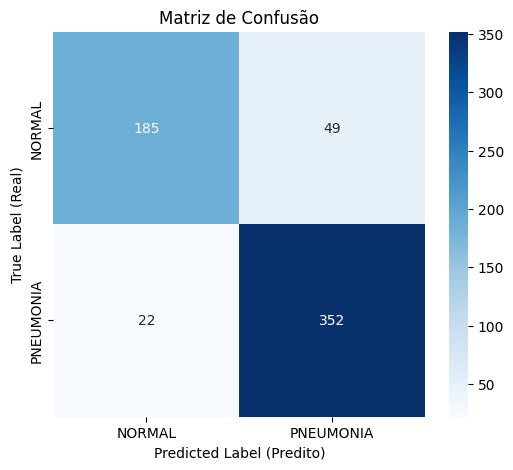


Métricas Detalhadas (Foco na Classe PNEUMONIA):
Precisão (Precision): 0.8778  <-- Proporção de acertos entre os preditos como PNEUMONIA
Recall (Sensibilidade): 0.9412    <-- Proporção de casos de PNEUMONIA que o modelo realmente encontrou
F1-Score: 0.9084


In [18]:
# Fazer previsões no conjunto de teste
# O modelo retorna probabilidades (0 a 1)
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Converter probabilidades em classes binárias (0 ou 1)
# 0: Normal, 1: Pneumonia
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Obter as classes reais do conjunto de teste
y_true = test_generator.classes[:len(y_pred_classes)] # Garante que os tamanhos coincidam

# Calcular a Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Matriz de confusão 
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('True Label (Real)')
plt.xlabel('Predicted Label (Predito)')
plt.title('Matriz de Confusão')
plt.show()

# Cálculo de Métricas
# Flatten para garantir que as dimensões coincidam
y_true_flat = y_true.flatten()
y_pred_flat = y_pred_classes.flatten()

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print("\nMétricas Detalhadas (Foco na Classe PNEUMONIA):")
print(f"Precisão (Precision): {precision:.4f}  <-- Proporção de acertos entre os preditos como PNEUMONIA")
print(f"Recall (Sensibilidade): {recall:.4f}    <-- Proporção de casos de PNEUMONIA que o modelo realmente encontrou")
print(f"F1-Score: {f1:.4f}")

# 6. ACT ~ Desafios Encontrados e Próximos Passos

> **Esta fase sintetiza os achados e propõe um plano de ação para a implantação e aprimoramento do sistema de diagnóstico.**

---

 ### ✅ Resultados Finais no Teste (Desempenho Atingido)

| Métrica | Valor | Objetivo Clínico | Status |
| :--- | :---: | :--- | :--- |
| **Recall (Sensibilidade)** | **94,12%** | **Evitar Falsos Negativos (Risco de vida)** | ✅ Ótimo |
| **F1-Score** | 90,84% | Equilíbrio entre Precisão e Recall | ✅ Excelente |
| **Acurácia Global** | 88,32% | Medida geral de acerto | ✅ Bom |
| **Precisão (Precision)** | 87,78% | Evitar Falsos Positivos (Custos/Estresse) | ⚠️ Melhorar |
| **Especificidade** | 79,00% | Garantir a Correta Identificação de Pacientes Saudáveis | ⚠️ Melhorar |

 <p style="font-size:1em; color:#333; font-style: italic; text-align: center;">
    Foi possível alcançar resultados satisfatórios, especialmente considerando a complexidade do problema e a limitação de dados.
</p>

<br>

Foram aplicadas técnicas de data augmentation, dropout e early stopping para melhorar a generalização.

Entretanto, a área da saúde costuma exigir padrões de desempenho mais rigorosos, especialmente em sistemas que auxiliam ou automatizam diagnósticos. Em geral, modelos clínicos de referência buscam atingir **sensibilidade e especificidade acima de 90–95%** para garantir segurança diagnóstica e confiabilidade antes de qualquer uso real em pacientes.

## 6.1 Desafios Encontrados (Durante o Treinamento)

* Overfitting (Atingido pelo EarlyStopping): O loss no treino continua caindo, mas o val_loss para de cair ou começa a subir.

*  Desbalanceamento de Classes: O dataset de pneumonia é notavelmente desbalanceado (muito mais imagens de PNEUMONIA do que NORMAL no conjunto de treino). Isso pode inflar a métrica de accuracy (acurácia) enquanto **prejudica a precision** e recall para a classe minoritária.

* **Treinamento durando mais que o esperado na CPU, menor valor atingido foi cerca de 20 minutos.**

## 6.2 Estratégias de Melhoria (Recomendação)

* Balanceamento de Classes: Aplicar técnicas como pesos de classe (class_weight no model.fit) para dar maior importância aos exemplos da classe minoritária (NORMAL) durante o treinamento, ou técnicas de oversampling/undersampling.

* Transfer Learning (Melhoria Avançada): Substituir a arquitetura simples por uma rede pré-treinada em milhões de imagens (ex: VGG16 ou ResNet), cujos pesos iniciais são excelentes em reconhecimento de características. Isso acelera o treinamento e melhora a precisão.

* Aumento de Dados Otimizado: Ajustar os parâmetros do ImageDataGenerator (rotação, zoom, etc.) para que simulem melhor a variabilidade esperada em radiografias.